In [2]:
! pip install torch

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
   - -------------------------------------- 9.4/204.1 MB 53.3 MB/s eta 0:00:04
   ---- ----------------------------------- 22.5/204.1 MB 57.0 MB/s eta 0:00:04
   ------ --------------------------------- 35.1/204.1 MB 57.2 MB/s eta 0:00:03
   --------- ------------------------------ 47.4/204.1 MB 57.0 MB/s eta 0:00:03
   ----------- ---------------------------- 60.3/204.1 MB 57.3 MB/s eta 0:00:03
   -------------- ------------------------- 72.6/204.1 MB 57.9 MB/s eta 0:00:03
   ---------------- ----------------------- 84.7/204.1 MB 57.5 MB/s eta 0:00:03
   ------------------ --------------------- 95.7/204.1 MB 56.5 MB/s eta 0:00:02
   -------------------- ------------------ 109.1/204.1 MB 57.0 MB/s eta 0:00:02
   ----------------------- --------------- 122.2/204.1 MB 57.8 MB/s eta 0:00:02
   ------------------------- ------------- 134.7/204


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\Pedro\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [16]:
import random
import collections
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from gymnasium.wrappers import RecordVideo
import os

# --- Buffer de Reproducción ---
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = collections.deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states),
                np.array(actions),
                np.array(rewards, dtype=np.float32),
                np.array(next_states),
                np.array(dones, dtype=np.float32))
    
    def __len__(self):
        return len(self.buffer)

# --- Definición de la Red Neuronal (DQN) ---
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )
    
    def forward(self, x):
        return self.fc(x)

# --- Agente DQN ---
class DQNAgent:
    def __init__(self, env, lr=1e-3, gamma=0.99, epsilon=1.0, 
                 epsilon_decay=0.995, min_epsilon=0.01,
                 buffer_capacity=10000, batch_size=64, 
                 target_update=10, device='cpu'):
        
        self.env = env
        self.device = torch.device(device)
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.batch_size = batch_size
        self.target_update = target_update
        
        # Redes: policy (online) y target
        self.policy_net = DQN(self.state_dim, self.action_dim).to(self.device)
        self.target_net = DQN(self.state_dim, self.action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.replay_buffer = ReplayBuffer(buffer_capacity)
        self.steps_done = 0

    def select_action(self, state):
        self.steps_done += 1
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.policy_net(state_tensor)
        return int(torch.argmax(q_values, dim=1).item())

    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        states      = torch.FloatTensor(states).to(self.device)
        actions     = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards     = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones       = torch.FloatTensor(dones).unsqueeze(1).to(self.device)
        
        # Q-valor actual según la red policy
        current_q_values = self.policy_net(states).gather(1, actions)
        
        # Q-valor siguiente usando la red target
        next_q_values = self.target_net(next_states).max(1)[0].unsqueeze(1)
        target_q_values = rewards + self.gamma * next_q_values * (1 - dones)
        
        loss = nn.MSELoss()(current_q_values, target_q_values.detach())
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Actualizar epsilon (estrategia ε-greedy)
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)
    
    def train(self, num_episodes=500):
        self.episode_rewards = []
        self.episodes = []
        for episode in range(num_episodes):
            state, _ = self.env.reset()
            total_reward = 0
            done = False
            episode_data = []
            while not done:
                action = self.select_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                self.replay_buffer.push(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward
                episode_data.append((state, action, reward))
                self.update()
            # Cada cierto número de episodios se actualiza la red target
            if episode % self.target_update == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())
            self.episode_rewards.append(total_reward)
            self.episodes.append(episode_data)
            print(f"Episode {episode+1}: reward {total_reward}, epsilon {self.epsilon:.3f}")
        return self.episode_rewards
    
    def setup_video_recording(self, render_interval=-1, video_path=None):
        """
        Configura la grabación de videos si se proporciona un directorio de almacenamiento.
        Args:
            render_interval (int, opcional): Frecuencia de grabación de episodios.
            video_path (str, opcional): Directorio donde almacenar videos.
        """
        if video_path:
            env_name = self.env.spec.id if self.env.spec else "UnknownEnv"
            env_dir = os.path.join(video_path, env_name)
            model_name = str(self).replace("=", "").replace(",", "").replace(" ", "_")
            model_dir = os.path.join(env_dir, model_name)
            os.makedirs(model_dir, exist_ok=True)
            # Se utiliza RecordVideo para envolver el ambiente
            self.env = RecordVideo(self.env, model_dir, episode_trigger=lambda episode: episode % render_interval == 0)

    def __str__(self):
        """
        Devuelve una representación en cadena del agente con sus parámetros actuales.
        """
        return (f'Qlearning(gamma={self.gamma}, epsilon={self.epsilon})')
    def stats(self):
        return{"episode_rewards": self.episode_rewards, "episodes": self.episodes}
    
# --- Optimización para CartPole-v1 ---
def optimize_for_cartpole():
    """
    Para CartPole-v1 se pueden optimizar algunos aspectos:
      1. La arquitectura de la red puede ser relativamente simple (por ejemplo, dos capas de 128 unidades).
      2. Usar un learning rate moderado (e.g., 1e-3) y aplicar decaimiento en epsilon para balancear exploración y explotación.
      3. El buffer de reproducción ayuda a romper correlaciones entre experiencias.
      4. La actualización periódica de la red target (cada 10 episodios en este ejemplo) aporta estabilidad.
    """
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    video_directory = "./videos"  # Directorio donde se almacenarán los videos
    agent = DQNAgent(env, lr=1e-3, gamma=0.99, epsilon=1.0, 
                      epsilon_decay=0.995, min_epsilon=0.01,
                      buffer_capacity=10000, batch_size=64, 
                      target_update=10, device='cpu')
    video_directory = "./videos"  # Directorio donde se almacenarán los videos
    agent.setup_video_recording(render_interval=100, video_path=video_directory)
    rewards = agent.train(num_episodes=500)
    return rewards

if __name__ == "__main__":
    optimize_for_cartpole()

Episode 1: reward 21.0, epsilon 1.000
Episode 2: reward 19.0, epsilon 1.000
Episode 3: reward 29.0, epsilon 0.970
Episode 4: reward 11.0, epsilon 0.918
Episode 5: reward 18.0, epsilon 0.839
Episode 6: reward 15.0, epsilon 0.778
Episode 7: reward 10.0, epsilon 0.740
Episode 8: reward 28.0, epsilon 0.643
Episode 9: reward 16.0, epsilon 0.594
Episode 10: reward 29.0, epsilon 0.513
Episode 11: reward 11.0, epsilon 0.486
Episode 12: reward 16.0, epsilon 0.448
Episode 13: reward 9.0, epsilon 0.429
Episode 14: reward 12.0, epsilon 0.404
Episode 15: reward 23.0, epsilon 0.360
Episode 16: reward 13.0, epsilon 0.337
Episode 17: reward 10.0, epsilon 0.321
Episode 18: reward 10.0, epsilon 0.305
Episode 19: reward 13.0, epsilon 0.286
Episode 20: reward 9.0, epsilon 0.273
Episode 21: reward 11.0, epsilon 0.258
Episode 22: reward 15.0, epsilon 0.240
Episode 23: reward 27.0, epsilon 0.209
Episode 24: reward 25.0, epsilon 0.185
Episode 25: reward 9.0, epsilon 0.177
Episode 26: reward 12.0, epsilon 0.16

In [17]:
import matplotlib.pyplot as plt
def plot_len_episodes(episodes):
  # Creamos una lista de índices para el eje x
  # Creamos el gráfico
  plt.figure(figsize=(6, 3))
  plt.plot(    [len(episode) for episode in episodes]
)
  # Añadimos título y etiquetas
  plt.title('Longirud de episodios por T')
  plt.xlabel('Episodio T')
  plt.ylabel('Número de pasos del episodio')
  # Mostramos el gráfico
  plt.grid(True)
  plt.show()

plot_len_episodes(agent.stats()["episodes"])
plot_len_episodes(agent.stats()["episodes"][0:500])

NameError: name 'agent' is not defined

In [ ]:
import random
import collections
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


# --- Buffer de Experiencia ---
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = collections.deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), np.array(next_states), np.array(dones, dtype=np.float32)
    
    def __len__(self):
        return len(self.buffer)

# --- Red Dueling DQN ---
class DuelingDQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DuelingDQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        
        # Stream de valor
        self.value_stream = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        # Stream de ventaja
        self.advantage_stream = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
        # Combinamos valor y ventaja: Q = V + (A - mean(A))
        q_vals = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_vals

# --- Agente DQN con Double DQN y Dueling Network ---
class DQNAgent:
    def __init__(self, env, lr=1e-3, gamma=0.99, epsilon_start=1.0, epsilon_decay=0.995, min_epsilon=0.01,
                 buffer_capacity=10000, batch_size=64, target_update_freq=10, device='cpu'):
        self.env = env
        self.device = torch.device(device)
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        
        # Inicializar redes: policy y target
        self.policy_net = DuelingDQN(self.state_dim, self.action_dim).to(self.device)
        self.target_net = DuelingDQN(self.state_dim, self.action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.replay_buffer = ReplayBuffer(buffer_capacity)
        self.steps_done = 0
    
    def select_action(self, state):
        self.steps_done += 1
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            with torch.no_grad():
                q_values = self.policy_net(state_tensor)
            return int(torch.argmax(q_values, dim=1).item())
    
    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        states      = torch.FloatTensor(states).to(self.device)
        actions     = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards     = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones       = torch.FloatTensor(dones).unsqueeze(1).to(self.device)
        
        # Q(s, a) según la red policy
        q_values = self.policy_net(states).gather(1, actions)
        
        # Double DQN: usar la red policy para seleccionar la acción y la red target para evaluarla
        with torch.no_grad():
            next_actions = self.policy_net(next_states).argmax(dim=1, keepdim=True)
            next_q_values = self.target_net(next_states).gather(1, next_actions)
            target_q_values = rewards + self.gamma * next_q_values * (1 - dones)
        
        loss = nn.MSELoss()(q_values, target_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        # Gradient clipping para estabilizar el entrenamiento
        nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()
        
        # Decaimiento de epsilon
    
    def train(self, num_episodes=500):
        self.episode_rewards = []
        self.episodes = []
        for episode in range(num_episodes):
            state, _ = self.env.reset()
            done = False
            total_reward = 0
            episode_data= []
            while not done:
                action = self.select_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                self.replay_buffer.push(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward
                episode_data.append((state, action, reward))
                
                self.update()

                self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)

            
            self.episode_rewards.append(total_reward)
            self.episodes.append(episode_data)
            # Actualizar la red target cada target_update_freq episodios
            if episode % self.target_update_freq == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())
            
            print(f"Episode {episode+1}, Reward: {total_reward}, Epsilon: {self.epsilon:.3f}")
        return self.episode_rewards
    
    def setup_video_recording(self, render_interval=-1, video_path=None):
        """
        Configura la grabación de videos si se proporciona un directorio de almacenamiento.
        Args:
            render_interval (int, opcional): Frecuencia de grabación de episodios.
            video_path (str, opcional): Directorio donde almacenar videos.
        """
        if video_path:
            env_name = self.env.spec.id if self.env.spec else "UnknownEnv"
            env_dir = os.path.join(video_path, env_name)
            model_name = str(self).replace("=", "").replace(",", "").replace(" ", "_")
            model_dir = os.path.join(env_dir, model_name)
            os.makedirs(model_dir, exist_ok=True)
            # Se utiliza RecordVideo para envolver el ambiente
            self.env = RecordVideo(self.env, model_dir, episode_trigger=lambda episode: episode % render_interval == 0)

    def __str__(self):
        """
        Devuelve una representación en cadena del agente con sus parámetros actuales.
        """
        return (f'Qlearning(gamma={self.gamma}, epsilon={self.epsilon})')
    
    def stats(self):
        return{"episode_rewards": self.episode_rewards, "episodes": self.episodes}

# --- Optimización para CartPole-v1 ---
"""
Para CartPole-v1 se recomienda:
    1. Usar una red relativamente simple (aquí dos capas ocultas de 128 unidades y streams dueling).
    2. Ajustar el learning rate (por ejemplo, 1e-3) y decaimiento de ε (inicialmente 1.0, decay=0.995).
    3. Emplear un replay buffer adecuado y actualizar la red target periódicamente.
    4. Aplicar técnicas como Double DQN y gradient clipping para mayor estabilidad.
"""
env = gym.make("CartPole-v1", render_mode="rgb_array")
agent = DQNAgent(env, lr=1e-4, gamma=0.95, epsilon_start=1.0, epsilon_decay=0.9995, min_epsilon=0.001,
                    buffer_capacity=100000, batch_size=256, target_update_freq=10, device='cpu')
video_directory = "./videos"  # Directorio donde se almacenarán los videos
agent.setup_video_recording(render_interval=100, video_path=video_directory)
rewards = agent.train(num_episodes=500)

def plot_len_episodes(episodes):
  # Creamos una lista de índices para el eje x
  # Creamos el gráfico
  plt.figure(figsize=(6, 3))
  plt.plot(    [len(episode) for episode in episodes]
)
  # Añadimos título y etiquetas
  plt.title('Longirud de episodios por T')
  plt.xlabel('Episodio T')
  plt.ylabel('Número de pasos del episodio')
  # Mostramos el gráfico
  plt.grid(True)
  plt.show()

plot_len_episodes(agent.stats()["episodes"])


Episode 1, Reward: 22.0, Epsilon: 0.989
Episode 2, Reward: 13.0, Epsilon: 0.983
Episode 3, Reward: 15.0, Epsilon: 0.975
Episode 4, Reward: 15.0, Epsilon: 0.968
Episode 5, Reward: 25.0, Epsilon: 0.956
Episode 6, Reward: 12.0, Epsilon: 0.950
Episode 7, Reward: 22.0, Epsilon: 0.940
Episode 8, Reward: 30.0, Epsilon: 0.926
Episode 9, Reward: 25.0, Epsilon: 0.914
Episode 10, Reward: 29.0, Epsilon: 0.901
Episode 11, Reward: 28.0, Epsilon: 0.889
Episode 12, Reward: 11.0, Epsilon: 0.884
Episode 13, Reward: 14.0, Epsilon: 0.878
Episode 14, Reward: 17.0, Epsilon: 0.870
Episode 15, Reward: 27.0, Epsilon: 0.859
Episode 16, Reward: 16.0, Epsilon: 0.852
Episode 17, Reward: 13.0, Epsilon: 0.846
Episode 18, Reward: 12.0, Epsilon: 0.841
Episode 19, Reward: 22.0, Epsilon: 0.832
Episode 20, Reward: 14.0, Epsilon: 0.826
Episode 21, Reward: 18.0, Epsilon: 0.819
Episode 22, Reward: 9.0, Epsilon: 0.815
Episode 23, Reward: 55.0, Epsilon: 0.793
Episode 24, Reward: 12.0, Epsilon: 0.788
Episode 25, Reward: 13.0, 

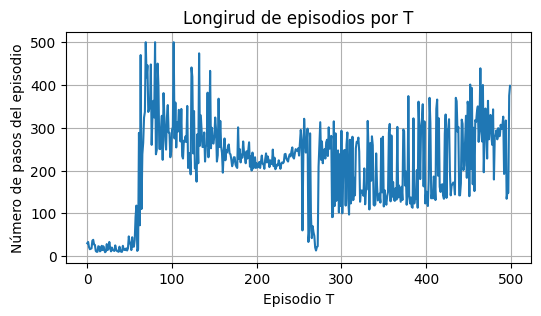

In [28]:
import matplotlib.pyplot as plt
def plot_len_episodes(episodes):
  # Creamos una lista de índices para el eje x
  # Creamos el gráfico
  plt.figure(figsize=(6, 3))
  plt.plot(    [len(episode) for episode in episodes]
)
  # Añadimos título y etiquetas
  plt.title('Longirud de episodios por T')
  plt.xlabel('Episodio T')
  plt.ylabel('Número de pasos del episodio')
  # Mostramos el gráfico
  plt.grid(True)
  plt.show()

plot_len_episodes(agent.stats()["episodes"])
